In [1]:
from langgraph.graph import MessagesState
from langchain_perplexity import ChatPerplexity
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage, RemoveMessage
from langgraph.graph import StateGraph, START
from langgraph.checkpoint.memory import InMemorySaver

In [2]:
load_dotenv()

True

In [3]:
model = ChatPerplexity()

In [4]:
class ChatState(MessagesState):
    summary: str

In [5]:
def summarize_conversation(state: ChatState):

    existing_summary = state["summary"]

    # Build summarization prompt
    if existing_summary:
        prompt = (
            f"Existing summary:\n{existing_summary}\n\n"
            "Extend the summary using the new conversation above."
        )
    else:
        prompt = "Summarize the conversation above."

    messages_for_summary = state["messages"] + [
        HumanMessage(content=prompt)
    ]

    response = model.invoke(messages_for_summary)

    # Keep only last 2 messages verbatim
    messages_to_delete = state["messages"][:-2]

    return {
        "summary": response.content,
        "messages": [RemoveMessage(id=m.id) for m in messages_to_delete],
    }

In [6]:
def chat_node(state: ChatState):
    messages = []

    if state["summary"]:
        messages.append({
            "role": "system",
            "content": f"Conversation summary:\n{state['summary']}"
        })

    messages.extend(state["messages"])

    print(messages)

    response = model.invoke(messages)
    return {"messages": [response]}

In [7]:
def should_summarize(state: ChatState):
    return len(state["messages"]) > 6

In [8]:
builder = StateGraph(ChatState)

builder.add_node("chat", chat_node)
builder.add_node("summarize", summarize_conversation)

builder.add_edge(START, "chat")

builder.add_conditional_edges(
    "chat",
    should_summarize,
    {
        True: "summarize",
        False: "__end__",
    }
)

builder.add_edge("summarize", "__end__")



In [9]:
checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

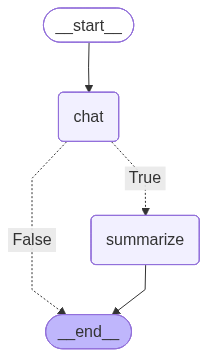

In [10]:
graph

In [11]:
config = {"configurable": {"thread_id": "t1"}}

def run_turn(text: str):
    out = graph.invoke({"messages": [HumanMessage(content=text)], "summary": ""}, config=config)
    return out

In [12]:
# gives the current version of the state
def show_state():
    snap = graph.get_state(config)
    vals = snap.values
    print("\n--- STATE ---")
    print("summary:", vals.get("summary", ""))
    print("num_messages:", len(vals.get("messages", [])))
    print("messages:")
    for m in vals.get("messages", []):
        print("-", type(m).__name__, ":", m.content[:80])

In [13]:
run_turn('Quantum Physics')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='a0023b0b-fed2-4df2-815a-b0c4aa6730ff')]

--- STATE ---
summary: 
num_messages: 2
messages:
- HumanMessage : Quantum Physics
- AIMessage : **Quantum physics** is the branch of physics that describes the behavior of matt


In [14]:
run_turn('How is Albert Einstien related?')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='a0023b0b-fed2-4df2-815a-b0c4aa6730ff'), AIMessage(content='**Quantum physics** is the branch of physics that describes the behavior of matter and energy at the smallest scales of the universe—atoms, electrons, and photons—where the rules fundamentally differ from classical physics[4][5].\n\n## Key Characteristics\n\n**Wave-particle duality**: Extremely small objects simultaneously exhibit properties of both particles and waves[3]. For example, electrons can be described as particles trapped in atoms, but also as waves with a mathematical "wave function" that represents the probability of finding them at specific locations[3][5].\n\n**Quantization**: Particles in bound states (like electrons in atoms) can only possess discrete values for properties such as energy or momentum, rather than any value in a continuous range[3]. An electron can only occupy specific energy levels within an atom, unlike a b

In [16]:
run_turn('What are some of Einstien"s fampus work')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='a0023b0b-fed2-4df2-815a-b0c4aa6730ff'), AIMessage(content='**Quantum physics** is the branch of physics that describes the behavior of matter and energy at the smallest scales of the universe—atoms, electrons, and photons—where the rules fundamentally differ from classical physics[4][5].\n\n## Key Characteristics\n\n**Wave-particle duality**: Extremely small objects simultaneously exhibit properties of both particles and waves[3]. For example, electrons can be described as particles trapped in atoms, but also as waves with a mathematical "wave function" that represents the probability of finding them at specific locations[3][5].\n\n**Quantization**: Particles in bound states (like electrons in atoms) can only possess discrete values for properties such as energy or momentum, rather than any value in a continuous range[3]. An electron can only occupy specific energy levels within an atom, unlike a b

In [17]:
run_turn('Explain special theory of relativity')
show_state()

[HumanMessage(content='What are some of Einstien"s fampus work', additional_kwargs={}, response_metadata={}, id='c08104a7-d2ae-4266-8ae5-1a5796a49f39'), AIMessage(content="**Albert Einstein's most famous works revolutionized physics and include the theories of special and general relativity, the photoelectric effect, and contributions to quantum mechanics.**[4][6]\n\n## Major Discoveries and Theories\n\n**Special Theory of Relativity (1905)**: Einstein's groundbreaking equation E=mc² demonstrates the equivalence of mass and energy[3][4]. The theory revealed that objects in motion experience time differently and that time and space are relative concepts linked to the speed of light[3].\n\n**General Theory of Relativity (1915)**: This extended special relativity to incorporate gravitation, proposing that massive objects cause distortions in spacetime rather than exerting a constant force[3][4]. Einstein's equivalence principle, formulated in 1907, became foundational to this theory[4].\n